In [ ]:
#classification of CIFAR10 images

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import TensorDataset,DataLoader,Subset

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download + load training set
train = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)

# Download + load test set
dev = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s]


In [4]:
print(type(dev))

<class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
print(train.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
print(train.data.shape)

(50000, 32, 32, 3)


In [7]:
print(dev.data.shape)

(10000, 32, 32, 3)


In [8]:
# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(dev,randidx[:6000]) # Subset for devset
testset = Subset(dev,randidx[6000:]) # Subset for test

In [9]:
print(type(devset))

<class 'torch.utils.data.dataset.Subset'>


In [10]:
print(len(devset))
print(len(testset))

6000
4000


In [11]:
# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(train,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

In [12]:
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([32, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


In [13]:
X.shape

torch.Size([32, 3, 32, 32])

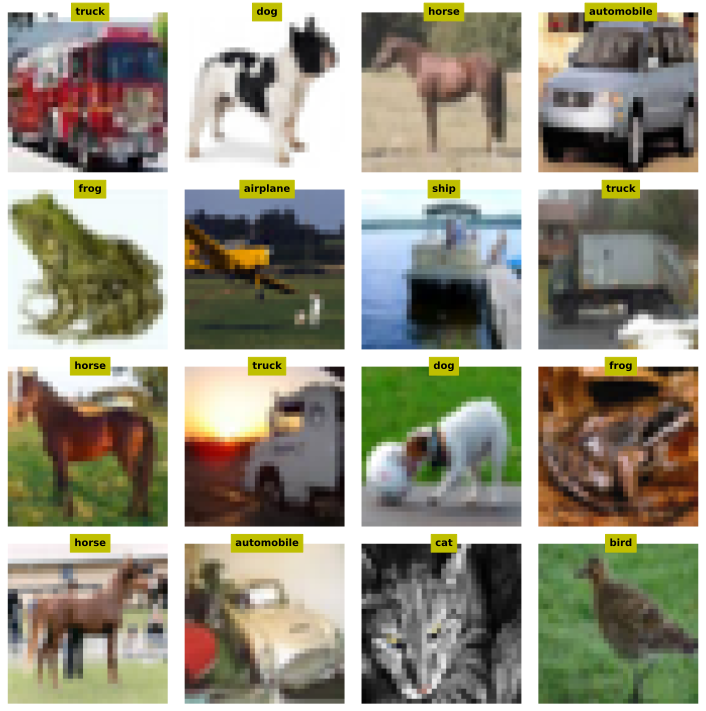

In [14]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# create a class for the model
def createTheCIFAR10Net(printtoggle=False):

  class cifarNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 3,10,3,padding=1)
      # size: np.floor( (32+2*1-3)/1 )+1 = 32/2 = 16 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,padding=1)
      # size: np.floor( (16+2*1-5)/1 )+1 = 14/2 = 7 (/2 b/c maxpool)

      ### fully-connected layer
      self.fc1 = nn.Linear(7*7*20,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = cifarNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [16]:
# test the model with one batch
net,lossfun,optimizer = createTheCIFAR10Net(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 3, 32, 32])
Layer conv1/pool1: torch.Size([32, 10, 16, 16])
Layer conv2/pool2: torch.Size([32, 20, 7, 7])
Vectorize: torch.Size([32, 980])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.2914, grad_fn=<NllLossBackward0>)


In [17]:
print(y.shape)
print(y.shape)

torch.Size([32])
torch.Size([32])


In [18]:
import time

# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheCIFAR10Net()

  net.to(device)

  # initialize losses
  trainLosses    = torch.zeros(numepochs)
  devLosses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc   = []

  start_time = time.time()


  # loop over epochs
  for epochi in range(numepochs):
    print("Start of Epoch", epochi, "at", round(time.time() - start_time, 2), "seconds")
    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)

      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append(accuracyPct.item())              # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    trainLosses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
    devsetAcc.append(devAcc.item())

    lossdev = lossfun(yHat,y)

    devLosses[epochi] = lossdev.item()


  # end epochs

  # function output
  return trainAcc,devsetAcc,trainLosses,devLosses,net


In [19]:
trainAcc,devsetAcc,trainLosses,devLosses,net = function2trainTheModel()

Start of Epoch 0 at 0.0 seconds
Start of Epoch 1 at 18.73 seconds
Start of Epoch 2 at 35.06 seconds
Start of Epoch 3 at 52.35 seconds
Start of Epoch 4 at 69.11 seconds
Start of Epoch 5 at 85.68 seconds
Start of Epoch 6 at 102.43 seconds
Start of Epoch 7 at 118.88 seconds
Start of Epoch 8 at 135.0 seconds
Start of Epoch 9 at 151.87 seconds


In [33]:
#calc test accuracy
net.eval()
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

with torch.no_grad(): # deactivates autograd
  yHat = net(X)

lossTest = lossfun(yHat,y).item()

# compare the following really long line of code to the training accuracy lines
TestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
TestAcc = TestAcc.cpu()

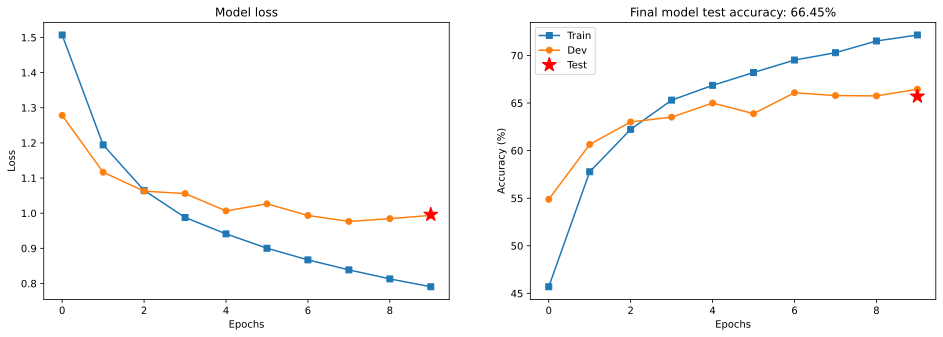

In [36]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLosses,'s-')
ax[0].plot(devLosses,'o-')
ax[0].plot(len(devLosses)-1,lossTest,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devsetAcc,'o-',label='Dev')
ax[1].plot(len(devsetAcc)-1,TestAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {devsetAcc[-1]:.2f}%')
ax[1].legend()

plt.show()